#### Dimensional Reduction 
##### Part I
Comparing PCA, the gold standard for dimensional reduction, to tSNE.

In [1]:
%matplotlib inline
import tSNE_utils # load utility functions

import numpy as np
import pandas as pd
import scipy as sc
# scikit packages
import skbio
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')
# import tsne package
import sys; sys.path.append('/Users/Cody/git/FIt-SNE')
from fast_tsne import fast_tsne

Load _.hdf5_ filetype using `h5py`

In [2]:
#load the hdf5 files into objects
r00 = tSNE_utils.read_hdf5("GSE102698ClosenessRep_0.hdf5")
r01 = tSNE_utils.read_hdf5("GSE102698ClosenessRep_1.hdf5")
r02 = tSNE_utils.read_hdf5("GSE102698ClosenessRep_2.hdf5")

Each matrix should be __375 cells__ wide and __25507 genes__ long

In [3]:
print('r00 = {}'.format(r00['Close_0.25'].shape)) # for example

r00 = (375, 25507)


Calculate a distance matrix for all 375 cells in one of the datasets using `scipy` spatial distance function
* 0.00 closeness set for this example
* replicate 1

In [4]:
dm_r00_000 = sc.spatial.distance_matrix(x=r00['Close_0.00'],y=r00['Close_0.00'])

---
#### Perform PCA
* log-2 normalization
* 50 PCs
* 0.00 closeness factor
* replicate 1

In [5]:
%%time

# PCA with 50 PCs on log2-transformed data
r00_000_PCA = PCA(n_components=50).fit_transform(np.log2(r00['Close_0.00']+1)) 

print('Shape of the resulting PC matrix:', r00_000_PCA.shape, '\n')

Shape of the resulting PC matrix: (375, 50) 

CPU times: user 964 ms, sys: 204 ms, total: 1.17 s
Wall time: 794 ms


---
#### Calculate correlation statistics for distance matrices

In [6]:
dm_r00_000_PCA = sc.spatial.distance_matrix(x=r00_000_PCA,y=r00_000_PCA)

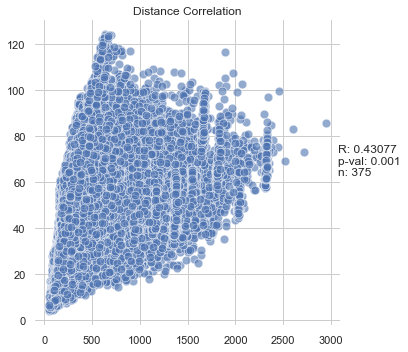

CPU times: user 2.15 s, sys: 26.7 ms, total: 2.18 s
Wall time: 2.24 s


In [10]:
%time raw_PCA_corr = tSNE_utils.corr_distances(dm_r00_000,dm_r00_000_PCA)

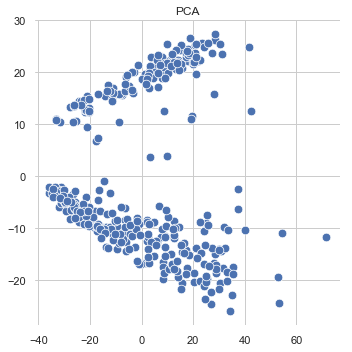

In [11]:
# Plot principal component analysis

plt.figure(figsize=(5,5))

sns.scatterplot(r00_000_PCA[:,0], r00_000_PCA[:,1], s=75)
plt.title('PCA')

sns.despine(left=True, bottom=True)
plt.tight_layout()

seems like there ar two distinct clusters, denoted by the value of their second principal component

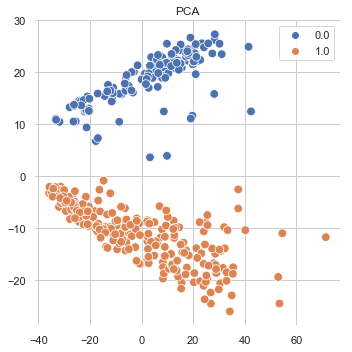

In [12]:
clusters = np.zeros(r00_000_PCA.shape[0])
clusters[np.where(r00_000_PCA[:,1] < 0)] = 1

# Plot principal component analysis

plt.figure(figsize=(5,5))

sns.scatterplot(r00_000_PCA[:,0], r00_000_PCA[:,1], s=75, hue = clusters)
plt.title('PCA')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Perform tSNE
use complete counts data

In [13]:
# This uses perplexity=30 (default) and random initialisation
%time r00_000_tSNE = fast_tsne(r00['Close_0.00'],seed=18,perplexity=30)

CPU times: user 69.5 ms, sys: 117 ms, total: 187 ms
Wall time: 13.7 s


In [14]:
dm_r00_000_tSNE = sc.spatial.distance_matrix(x=r00_000_tSNE,y=r00_000_tSNE)

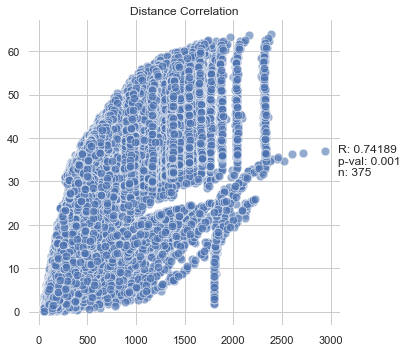

CPU times: user 2.15 s, sys: 32.7 ms, total: 2.18 s
Wall time: 2.23 s


In [17]:
%time raw_tSNE_corr = tSNE_utils.corr_distances(dm_r00_000,dm_r00_000_tSNE)

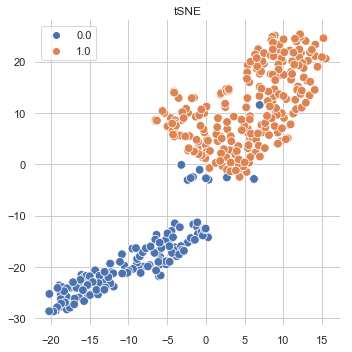

In [18]:
# plot tSNE results using PCA clustering

plt.figure(figsize=(5,5))

sns.scatterplot(r00_000_tSNE[:,0], r00_000_tSNE[:,1], s=75, hue = clusters)
plt.title('tSNE')

sns.despine(left=True, bottom=True)
plt.tight_layout()

---
#### Perform tSNE
use output of 50-component PCA to prime tSNE

In [19]:
# This uses perplexity=30 (default) and random initialisation
%time r00_000_PCAtSNE = fast_tsne(r00_000_PCA,seed=18,perplexity=30)

CPU times: user 2.72 ms, sys: 13.5 ms, total: 16.2 ms
Wall time: 9.72 s


In [20]:
dm_r00_000_PCAtSNE = sc.spatial.distance_matrix(x=r00_000_PCAtSNE,y=r00_000_PCAtSNE)

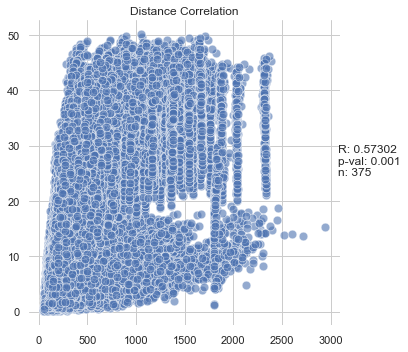

CPU times: user 2.22 s, sys: 113 ms, total: 2.33 s
Wall time: 2.42 s


In [21]:
%time raw_PCAtSNE_corr = tSNE_utils.corr_distances(dm_r00_000,dm_r00_000_PCAtSNE)

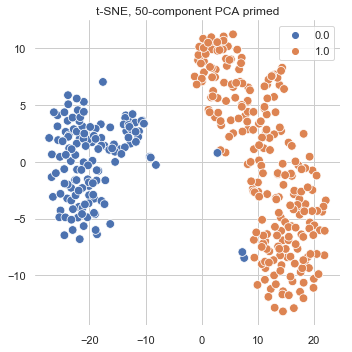

In [45]:
# plot results
plt.figure(figsize=(5,5))

sns.scatterplot(r00_000_PCAtSNE[:,0], r00_000_PCAtSNE[:,1], s=75, hue=clusters)
plt.title('t-SNE, 50-component PCA primed')

sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('tSNE.pdf')

Now run the Mantel test for a bunch of distance matrices and make sure the results are legit